# Домашнее задание «Элементарные методы анализа временных рядов»
Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd

In [2]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

# 1 Нестационарный ряд

In [5]:
mcs = pd.read_csv("monthly-car-sales-in-quebec-1960.csv")['Count']

Results of Dickey-Fuller Test:
Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


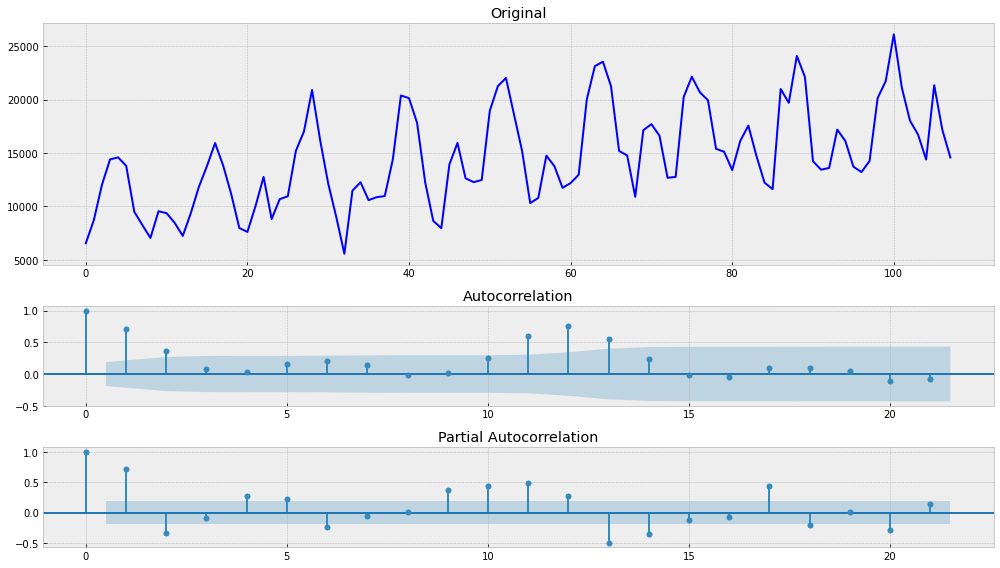

In [6]:
tsplot(mcs)

## 1.1 Скользящее среднее

In [7]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

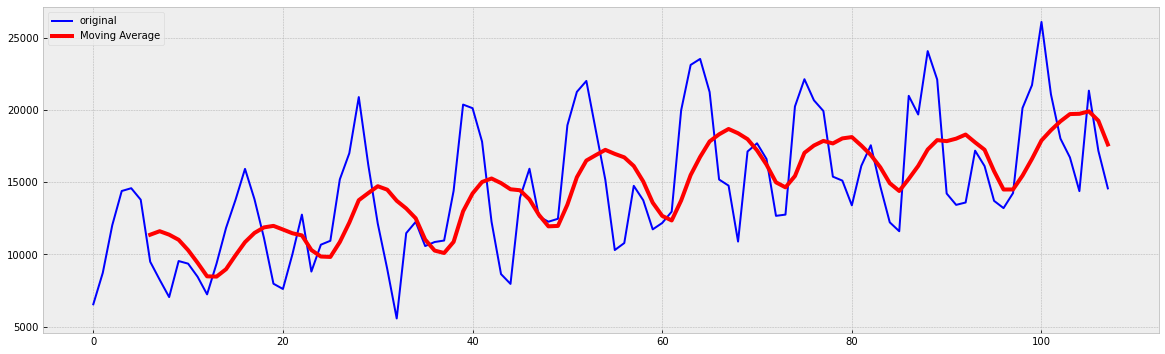

In [8]:
ser = moving_average(mcs, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(20, 6))
    plt.plot(mcs, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [9]:
train, test, val = mcs[:60], mcs[60:70], mcs[70:]

In [10]:
def mse11(X):
    alpha, beta, gamma = X
    result = moving_average(mcs, 7)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [11]:
opt = minimize(mse11, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [12]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 18738959.365306124
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0., 0.])


## 1.2 Взвешенная скользящая средняя

In [13]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

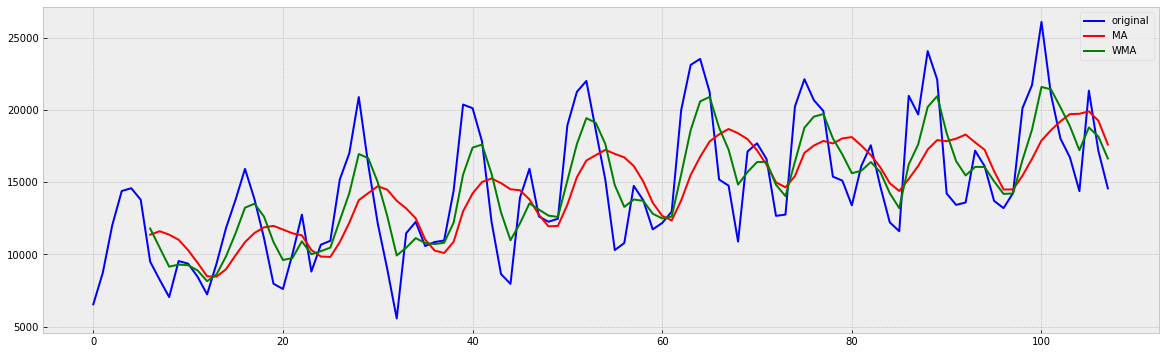

In [14]:
wma = weighted_moving_average(mcs, 7, [1,1,2,3,5,8,13]) # Числа Фиббоначи
ma = moving_average(mcs, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(20, 6))
    plt.plot(mcs, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

In [15]:
def mse12(X):
    alpha, beta, gamma = X
    result = weighted_moving_average(mcs, 7, [1,1,2,3,5,8,13])
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [16]:
opt = minimize(mse12, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [17]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 14691451.351331497
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0., 0.])


## 1.3 Экспоненциальное сглаживание

In [18]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

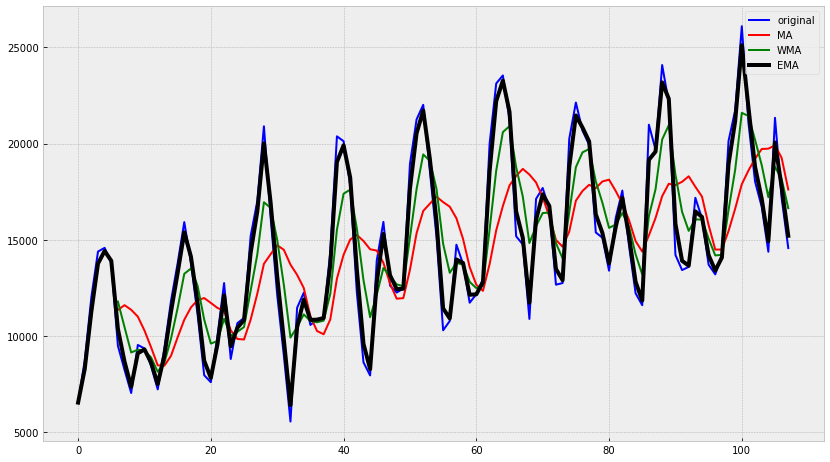

In [19]:
ema = exponential_moving_average(mcs, 0.8)
wma = weighted_moving_average(mcs, 7, [1,1,2,3,5,8,13])
ma = moving_average(mcs, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(mcs, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

In [20]:
def mse13(X):
    alpha, beta, gamma = X
    result = exponential_moving_average(mcs, 0.8)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [21]:
opt = minimize(mse13, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [22]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 25876604.39841131
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0., 0.])


## 1.4 Двойное экспоненциальное сглаживание

In [23]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [24]:
def plot_dema(alpha, beta):
    dema = double_ema(mcs, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(mcs, color='blue',label='original')
        plt.plot(ma, color='red', linewidth='2', label='MA')
        plt.plot(wma, color='green', linewidth='2', label='WMA')
        plt.plot(ema, color='black', linewidth='4', label='EMA')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

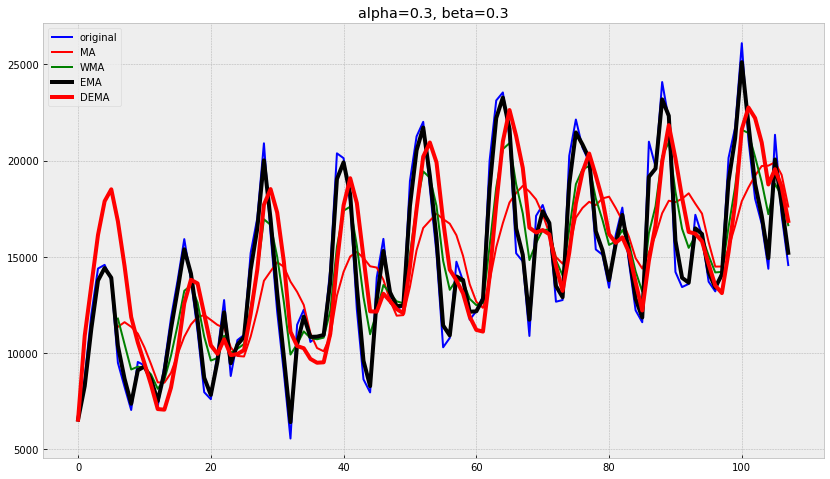

In [25]:
plot_dema(0.3, 0.3)

In [26]:
def mse14(X):
    alpha, beta, gamma = X
    result = double_ema(mcs, 0.3, 0.3)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [27]:
opt = minimize(mse14, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [28]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 13313694.29704291
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0., 0.])


## 1.5 Хольт - Винтерс

In [29]:
def initial_trend(series, season_len):
    i = 0
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len
    i += 1

In [30]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [31]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [32]:
def plot_tema(alpha, beta, gamma, ser=mcs, ser_to_plot=mcs, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

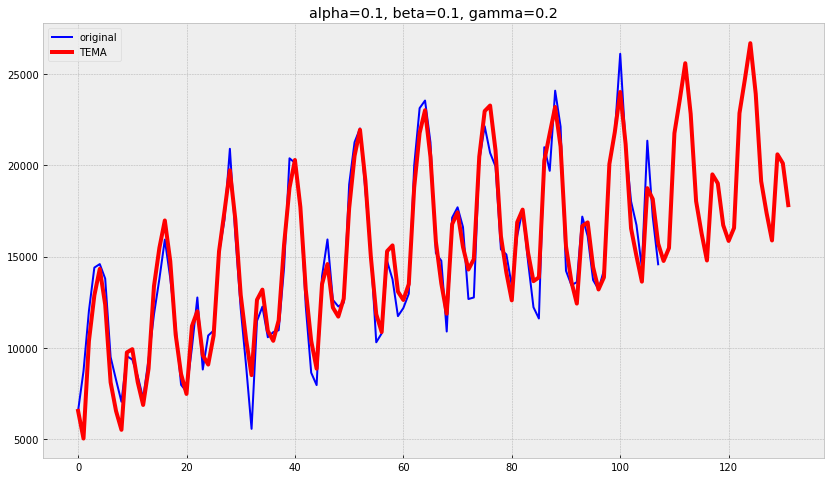

In [33]:
plot_tema(0.1, 0.1, 0.2)

In [34]:
def mse15(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(mcs, 12, 0.1, 0.1, 0.2, n_preds=24)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [35]:
opt = minimize(mse15, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [36]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 45118386.213161245
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0., 0.])


# 2 Стационарный ряд

In [37]:
mcs1 = boxcox(mcs, 0)

Results of Dickey-Fuller Test:
Test Statistic                 -1.452425
p-value                         0.556901
#Lags Used                     13.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


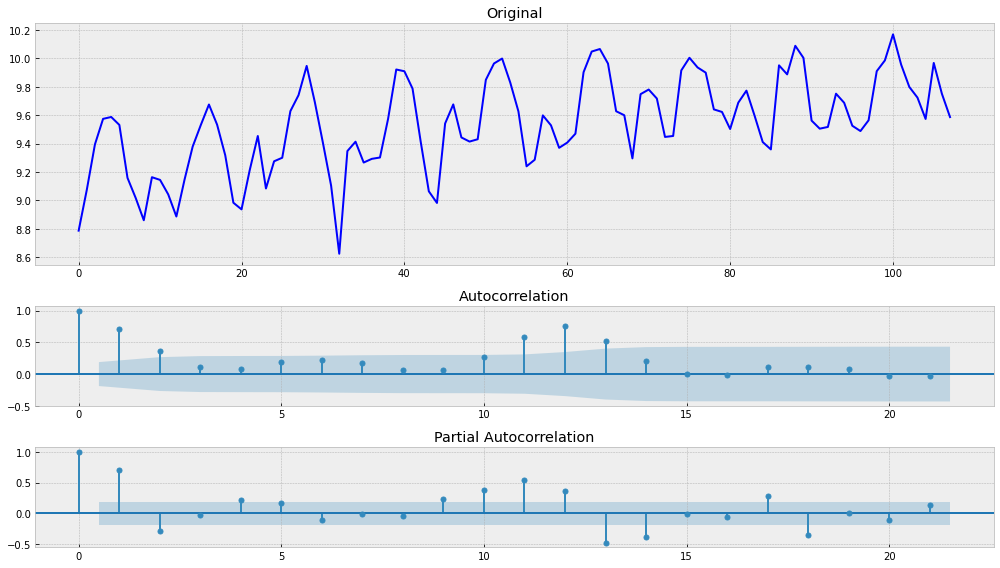

In [38]:
tsplot(mcs1)

In [39]:
mcs1 = mcs1[1:] - mcs1[:-1]

Results of Dickey-Fuller Test:
Test Statistic                 -4.193835
p-value                         0.000675
#Lags Used                     12.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


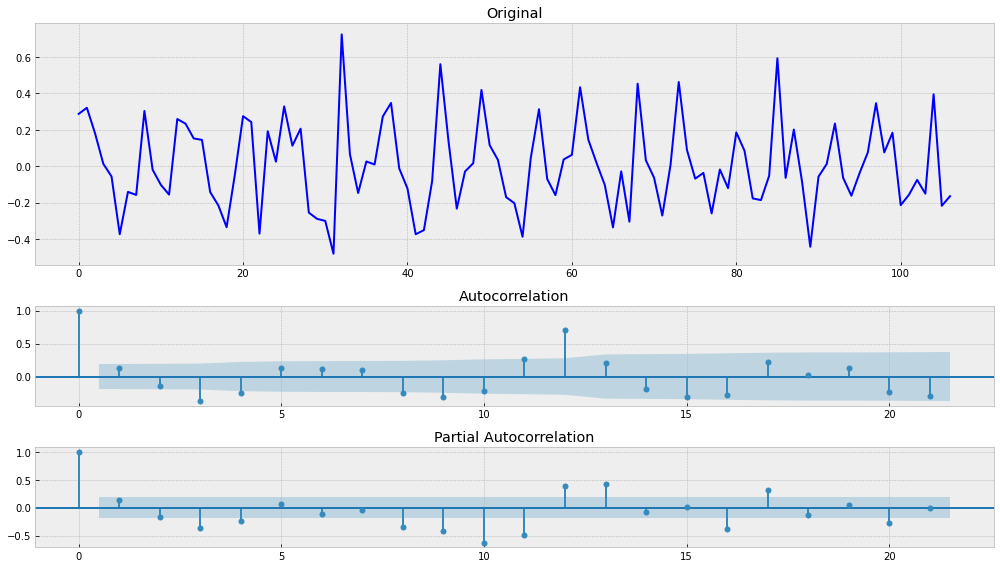

In [40]:
tsplot(mcs1)

Тест Дикки-Фуллера показывет значение p-value меньше 0,05, а значит мы привели ряд к стационарному.

## 2.1 Скользящее среднее

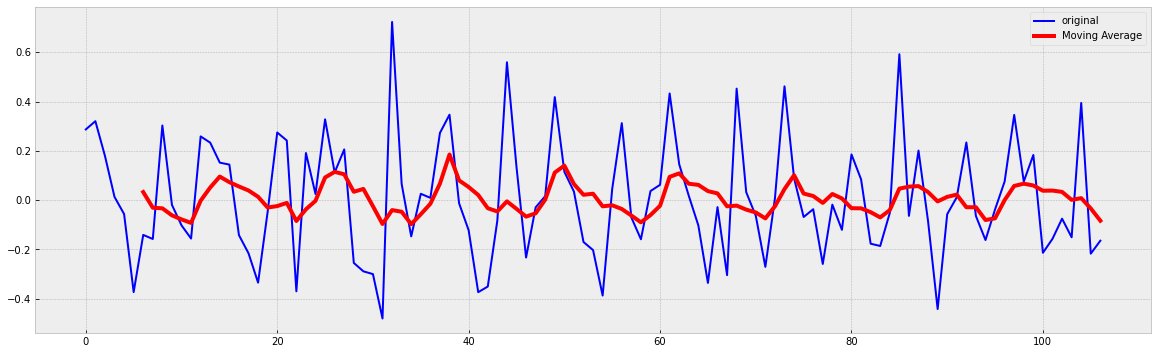

In [41]:
ser = moving_average(mcs1, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(20, 6))
    plt.plot(mcs1, color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [42]:
train, test, val = mcs1[:60], mcs1[60:70], mcs1[70:]

In [43]:
def mse21(X):
    alpha, beta, gamma = X
    result = moving_average(mcs1, 7)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [44]:
opt = minimize(mse21, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [45]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.06463791468816872
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0., 0.])


## 2.2 Взвешенная скользящая средняя

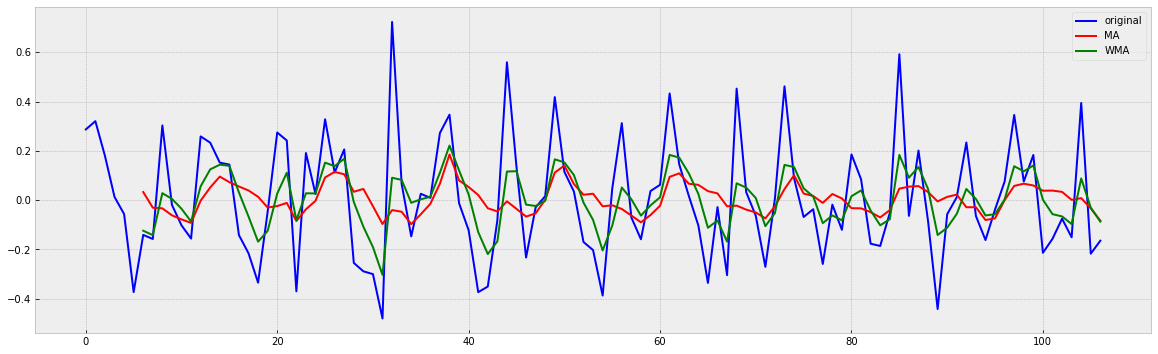

In [46]:
wma = weighted_moving_average(mcs1, 7, [1,1,2,3,5,8,13]) # Числа Фиббоначи
ma = moving_average(mcs1, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(20, 6))
    plt.plot(mcs1, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

In [47]:
def mse22(X):
    alpha, beta, gamma = X
    result = weighted_moving_average(mcs1, 7, [1,1,2,3,5,8,13])
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [48]:
opt = minimize(mse22, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [49]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.05862161780345989
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0., 0.])


## 2.3 Экспоненциальное сглаживание

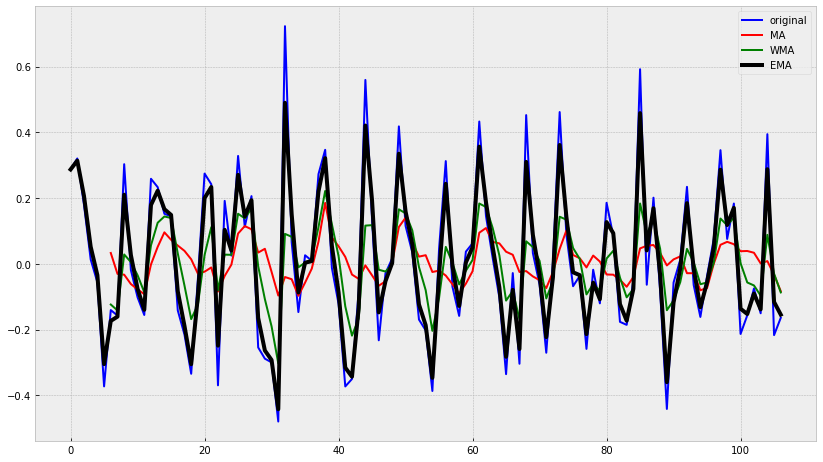

In [50]:
ema = exponential_moving_average(mcs1, 0.8)
wma = weighted_moving_average(mcs1, 7, [1,1,2,3,5,8,13])
ma = moving_average(mcs1, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(mcs1, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

In [51]:
def mse23(X):
    alpha, beta, gamma = X
    result = exponential_moving_average(mcs1, 0.8)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [52]:
opt = minimize(mse23, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [53]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.09574089444685227
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0., 0.])


## 2.4 Двойное экспоненциальное сглаживание

In [54]:
def plot_dema(alpha, beta):
    dema = double_ema(mcs1, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(mcs1, color='blue',label='original')
        plt.plot(ma, color='red', linewidth='2', label='MA')
        plt.plot(wma, color='green', linewidth='2', label='WMA')
        plt.plot(ema, color='black', linewidth='4', label='EMA')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

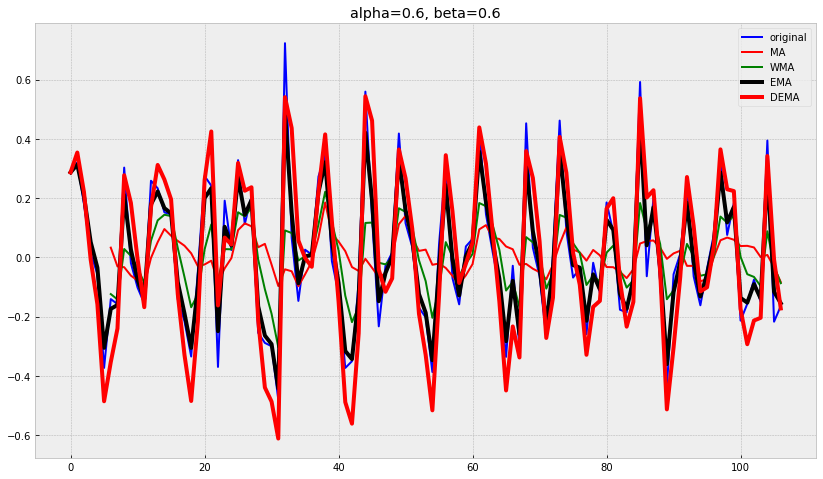

In [55]:
plot_dema(0.6, 0.6)

In [56]:
def mse24(X):
    alpha, beta, gamma = X
    result = double_ema(mcs1, 0.3, 0.3)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [57]:
opt = minimize(mse24, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [58]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.057059298352079804
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0., 0.])


## 2.5 Хольт - Винтерс

In [59]:
def plot_tema(alpha, beta, gamma, ser=mcs1, ser_to_plot=mcs1, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

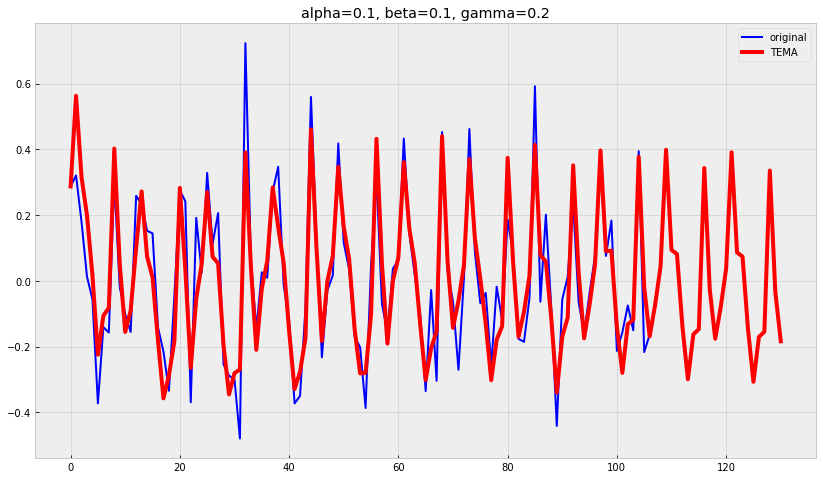

In [60]:
plot_tema(0.1, 0.1, 0.2)

In [61]:
def mse25(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(mcs1, 12, 0.1, 0.1, 0.2, n_preds=24)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [62]:
opt = minimize(mse25, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [63]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 0.10376886203630513
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0., 0.])


И на стационарном и на нестационарном рядах лучше всего отработала EMA. В принципе неплохо себя показали ТЕМА и DEMA, но DEMA был хуже.